In [7]:
import numpy as np 
import pandas as pd 
from pandas import Series 
import matplotlib.pyplot as plt 
import seaborn as sns 

#matplotlib 기본 scheme 말고 seaborn scheme 쓰기 위해서 .. 
#왜 그렇게 하는가? 일일이 그래프 폰트 사이즈 지정할 필요없이 seaborn font scale 사용
plt.style.use('seaborn')
sns.set

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls 

#ignore warnings
import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline 

In [6]:
#Dataset 불러오기
df_train = pd.read_csv('C:/Users/Lenovo/Desktop/데이터분석/train.csv')
df_test = pd.read_csv('C:/Users/Lenovo/Desktop/데이터분석/test.csv')

#Titanic1에서 설정했던 변수들 맞춰주기 
df_train['FamilySize'] = df_train['SibSp']+df_train['Parch']+1
df_test['FamilySize'] = df_test['SibSp']+df_test['Parch']+1

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i> 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i> 0 else 0)

3.1 Fill Null 
3.1.1 Fill Null in Age Using title

드디어 null data를 처리함,, 
여러가지 방법이 있지만 title+stat 사용하려고 함

영어 이름은 미스, 미슽터, 미세스 같은 타이틀을 사용 

pandas series에 data를 string으로 바꿔주는 stt method
그리고 정규표현식을 적용해주는 extract method를 사용하여 title 추출 가능

이 title을 initial column으로 저장 

In [8]:
#salutation(인사말?? ex. Dear Sir 여기서는 Mr,Ms) 추출
df_train['Initial']=df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial']=df_test.Name.str.extract('([A-Za-z]+)\.')

In [9]:
#방금 추출한 initial 과 Sex간의 카운트 비교 by pandas crosstab

pd.crosstab(df_train['Initial'],df_train['Sex']).T.style.background_gradient(cmap='winter_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


위의 crosstab table을 사용하여 남녀가 사용한 initial 구분하고 이를 replace method를 활용하여 원하는 값으로 대체 

In [10]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [11]:
#Initial에 따른 다른 변수값을 확인해보자 

df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


여성이 주로 사영하는 Miss, Mrs 에서 생존률 높은 거 확인 가능

본격적으로 Null data를 채울 차례!! 

Null을 처리하는 데는 다양한 방식이 있음
- statistics를 활용
- 데이터를 기반으로 머신러닝 알고리즘 예측값 넣기 

여기서는 statistics 활용 

여기서 statistics는 바로 >>train data<< 를 의미 

우리는 언제나 test를 unseen으로 둬야하기 때문에 train의 statistics를 기반으로 null data를 채움 

--->>> 이게 무슨 의미일까,,? test를 unseen으로 둬야하기 때문에 통계량을 사용한다??

In [12]:
#train data의 stat 확인

df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


우리는 Age Column을 보고있으니까.. Age 평균으로 Age Null data 채움 

★pandas dataframe을 다룰 때는 boolean array를 이용해 indexing 하는 방법이 편리함★

df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33

이 코드는 조건문 두 개가 걸려있음

Age가 null이고 initial이 Mr인 조건을 만족하는 탑승객의 Age값을 33으로 치환하겠다! (정확히는 32.73...)

이런식으로 일일히.,,표에 있는 평균값을 넣어주세요^^! 
(+test data도 빠트리지말고)

In [13]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

Null을 채우는 다른 방법은 없을까????
https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

단순히 age평균이 아니라 다른 컬럼값이 비슷한 데이터들의 median값 사용 

Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

3.1.2 Fill Null in Embarked
Age 했으니까 Embarked의 Null도 채워보자 

In [14]:
print('Embarked has', sum(df_train['Embarked'].isnull()),'Null')

Embarked has 2 Null


In [16]:
sum(df_train['Embarked'].isnull())

2

Embarked의 Null은 딸랑 2개다.. 가장 많은 탑승객이 탔던 S로 넣어주겠다 

이렇게 몇개 안될 때는 fillna method를 사용한다(맨 처음 배우는 방법)

In [19]:
df_train['Embarked'].fillna('S',inplace=True)

#왜 test data를 빼먹으셨을까..? 
df_test['Embarked'].fillna('S',inplace=True)

3.2 Change Age

현재 Age Column은 연속된 데이터다! 
이대로도 모델을 세울 수 있지만 grouping하여 카테도리로 만들어줄 수도 있다~

※연속 데이터를 카테고리 데이터로 바꿔버리면 information loss가 생길 수 있으니 주의해야함 

(하지만 다양한 방법을 배우는게 목적이니 진행)

☆☆☆☆☆continuous >>> category 하는 방법☆☆☆☆☆

① dataframe의 indexing 방법(.loc)로 직접 하나하나 하기 
② apply에 함수 넣어주기(간단) 

In [20]:
#dataframe의 indexing 방법(.loc)

df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

In [22]:
#apply에 함수 넣어주는 방법

def cat_age(x):
    if x<10:
        return 0
    elif x<20:
        return 1 
    elif x<30:
        return 2
    elif x<40:
        return 3
    elif x<50:
        return 4
    elif x<60:
        return 5
    elif x<70:
        return 6
    else:
        return 7
    
df_train['Age_cat_2']=df_train['Age'].apply(cat_age)
df_test['Age_cat_2']=df_test['Age'].apply(cat_age)

제대로 했다면 두가지 방법의 결과(Age_cat, Age_cat_2)가 같아야하므로 
확인해보자 

In [24]:
(df_train['Age_cat'] == df_train['Age_cat_2']).all()

True

두 컬럼은 일치함,, 이제 중복되는 Age_cat컬럼과 원래 컬럼 삭제 

In [25]:
df_train.drop(['Age', 'Age_cat_2'], axis=1,inplace=True)
df_test.drop(['Age', 'Age_cat_2'], axis=1,inplace=True)

3.3 Change Initial, Embarked and Sex (string ->> numerical)

현재 Initial은 Mr, Mrs, Miss, Master, Other 총 5개로 구성
Embarked 역시 S,C,Q 세개로 구성

이런 카테고리 데이터를 모델에 인풋으로 사용하려면 컴퓨터가 인식할 수 있도록 수치화시켜야함 

How?? Map method로 간단하게 할 수 있음 
사전 순서대로 정리하여 mapping(integer 하나씩 부여)

In [26]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

Embarked도 동일한 방식으로 mapping해주면 된다 
그러나 그 전에 정말로 Embarked가 S,C,Q 문자열데이터로만 구성되었는지 확인해보자 

In [27]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [28]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [29]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

Embarked의 string data를 integer로 바꿔주었지만,, null data가 사라졌는지 확인해보자 

Embarked column만 가져온 것은 하나의 pandas Series의 객체이므로 
isnull() method를 써서 series의 값이 null인지 아닌지 boolean으로 알 수 있음 

여기에다가 any()를 더해서 쓰면 True가 하나라도 있을때 True를 반환해준다
이때 True는 null이 있었다는 뜻

In [31]:
df_train['Embarked'].isnull().any()

False

In [33]:
#Sex Column도 numerical data로 바꿔보자(by Mapping)

df_train['Sex'] = df_train['Sex'].map({'female':0,'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0,'male':1})

자 이제 드디어..

각 Feature간의 상관관계를 구해보려고 함!!!!!!
여기서는 Pearson correlation을 사용 
-1에 가까울수록 음의 상관관계 +1에 가까울수록 양의 상관관계 

feature가 여러개이므로 한꺼번에 보려면 matrix형태가 편함
->> 이를 heatmap plot이라고 한다(+색까지 칠해져있는)

heatmap은 어떻게 그리나요??
dataframe의 corr() method + seaborn

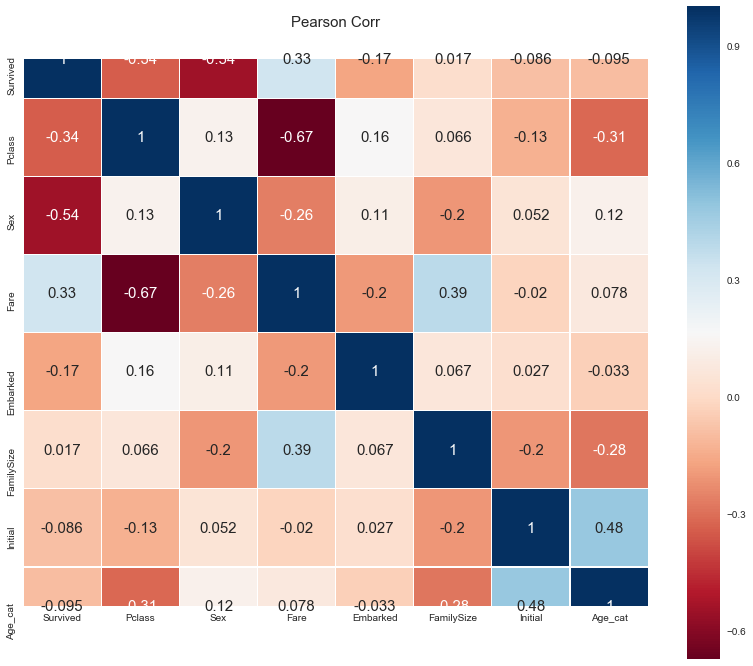

In [38]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 
                        'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu

plt.figure(figsize=(14,12))
plt.title('Pearson Corr', y=1.05, size=15)

sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', 
            annot=True, annot_kws={'size':15})

del heatmap_data

여기서 주목할 것은 Survived,, 
이전에 봤듯이 Sex와 Pclass가 눈에 띄는 음의 상관관계

Sex는 0이 여성이고 1이 남성이므로.. 
여성이 생존률이 높음이 음의 상관관계로 드러났고 

Pclass 역시 1>2>3 순으로 생존률이 높다는 것을 볼 수 있음 

이외에 Fare와 Embarked도 어느정도 상관관계가 있음을 확인

생각보다 Age와의 상관관계는 크게 두드러지지 않음,, 카테고리화해서 그랬을까???

또하나 확인해봐야하는거 
★Feature들 간의 상관관계★
만약 feature들 간의 강한 상관관계가 있다면 이들의 교호작용을 고려해주어야 한다
또한 이는 해당 두 가지 feature로 사실상 하나의 정보를 얻을 수 있다는 의미이다

다행히 여기서는 그런 관계는 눈에 보이지 않음 

이제 모델을 학습시키기 전의 데이터 전처리 과정을 해보자! 

3.4 One-hot encoding on Initial and Embarked 

아까 수치화했던 카테고리 데이터를 그대로 사용해도 된다! 

그러나 모델의 성능을 높이기 위해 ★one-hot enconding★을 하겠음 

우리가 아까했던 수치화: 간단하게 각 항목들을 숫자에 mapping 
one-hot encoding: 위의 카테고리를 (0,1)로 이루어진 5차원 벡터로 표현 
~쉽게말해 5x5 단위행렬처럼 만들겠다는 말~

이를 직접 코딩해서 만들어도 되고 >>pandas의 get_dummies<<를 사용하면 쉽게 만들 수 있음

5개의 카테고리니 one-hot encoding작업을 통해 5개의 새 컬럼이 생김 

In [39]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [40]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [41]:
#Embarked에도 적용 

df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

pandas의 get_dummies 외에도 sklearn의 Labelencoder + OneHotencoder를 써서 할 수도 있다 

만약 카테고리가 100개가 넘어갈 때 이 방법을 적용한다면 컬럼이 100개 이상 새로 만들어져 모델 적용에 어려움이 생길 수 있다. 이때는 적합하지 않음

3.5 Drop Columns

모델에 필요없는 컬럼은 다 지우자 필요없는거 삭제!!!

In [42]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [43]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [44]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1
